
# Data Processing Example - TRKR

In [1]:
# General imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import experimentdataanalysis.analysis.dataframe_plotting as dfplot
import experimentdataanalysis.data_io.csv_to_dataframe as csv2df

In [2]:
# import jtplot submodule from jupyterthemes IF installed
import importlib
jtplot_found = importlib.util.find_spec("jupyterthemes.jtplot") is not None
if jtplot_found:
    from jupyterthemes import jtplot
    # - currently installed theme will be used to
    jtplot.style(ticks=False, grid=False, fscale=1.6)
    # set the default figure size
    jtplot.figsize(x=6., y=6.)
    # needed to avoid spurious error messages with imshow...
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")


## Load data

Run IDs found: [19, 20, 21, 22, 23, 24]


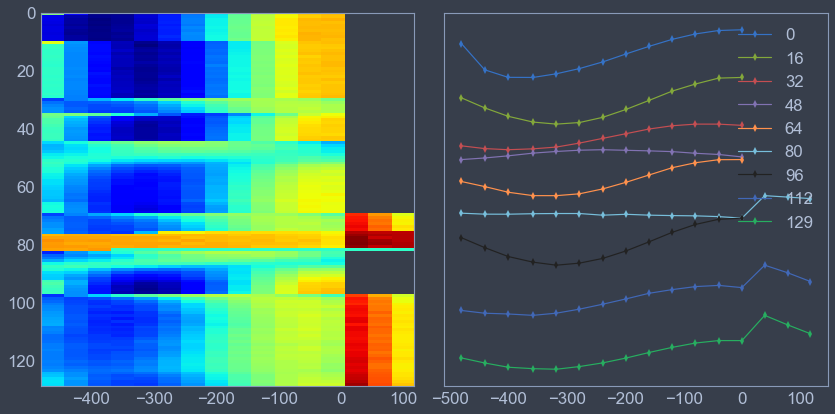

scancoord  kerr_rotation scan_type_2d scan_type_1d  \
run_id index_2d index_1d                                                       
19     1.0      0         -480.1108        0.01925   b_external  probe_delay   
                1         -440.2216       -0.05540   b_external  probe_delay   
                2         -400.0554       -0.07685   b_external  probe_delay   
                3         -360.1662       -0.07715   b_external  probe_delay   
                4         -320.0000       -0.06670   b_external  probe_delay   

                              lockin2x  lockin2r  lockin1r  voltage  \
run_id index_2d index_1d                                              
19     1.0      0         6.611400e-43  0.000878   0.01850      0.0   
                1         1.151400e-02  0.001702   0.05595      0.0   
                2         1.188120e-02  0.001590   0.07695      0.0   
                3         1.667400e-03  0.001778   0.07725      0.0   
                4         1.157440e-02  0.001706   0.06670      0.0   

                          laserpower  cwetalon       laser_h       laser_v  \
run_id index_2d index_1d                                                     
19     1.0      0              0.769    -0.144  8.330000e-22 -9.967000e-10   
                1              0.771    -0.143  1.100000e-32 -3.860000e-01   
                2              0.773    -0.137  6.233000e-01 -1.000000e-03   
                3              0.770    -0.139  9.921000e+00  1.000000e-03   
                4              0.765    -0.135  9.140000e-01 -9.640000e-01   

                          temperature  file_index  b_external  wavelength  
run_id index_2d index_1d                                                   
19     1.0      0              10.030          10       200.0       818.6  
                1              10.022          10       200.0       818.6  
                2              10.009          10       200.0       818.6  
                3               9.995          10       200.0       818.6  
                4               9.996          10       200.0       818.6

In [13]:
# UNITS: 
# time: ps
# b-field: mT
# voltages: V

# REQUIRED: directory containing 2D scans
parent_dir = ('C:\\Data\\feb2017_data_part2\\170217')

# ***just for convenience***
# target_keyword defines a this-must-be-in-filepath filter later
# y_aliases are used to rename the relevant column and bring to front
target_keyword = "TRKR_FieldScanTesting"
csv_file_y_alias = "lockin1x"
new_y_alias = "kerr_rotation"

# REQUIRED: data storage format information
delimiter = '\t'
trailing_delimiters = True  # rows end in delimiters
num_headerlines = 4
column_names_row = 0  # NOT counting skipped lines from num_headerlines
overwriting_column_names = []

if not overwriting_column_names:
    overwriting_column_names = None
pandas_read_csv_kwargs = {
     'skiprows': num_headerlines,
     'header': column_names_row,
     'names': overwriting_column_names,
     'delimiter': delimiter,
}
if trailing_delimiters:  # needed to avoid problems
    pandas_read_csv_kwargs['index_col'] = False

# REQUIRED: filename key for data files, will load only these
filename_key = '.dat'

# REQUIRED: criteria for grouping runs
# run_criteria = 'same'  # all same run ID, for 3D scans w/ 1 index_2d
run_criteria = 'directory'  # default

# OPTIONAL: filepath parsing rules
# DEFAULT SEARCH TERMS AND SEARCH RULES:
# 1. If first string found, register second string as
#    tag containing third string/value
#        e.g. if keyword_list contains ("warmup", "Warmup?", "Yes"):
#             "...warmup..." -> {"Warmup?": "Yes"}
this_element_keyword_list = []
# 2. Grab next element(s) if this one CONTAINS first string,
#    tag next element(s) as second string(s)
#        e.g. "..._Ind_3_..." -> {"FastScanIndex": 3}
#        e.g. "..._2Dscan_MirrorY_MirrorZ_..."
#                 -> {"SecondScanType": "MirrorY",
#                     "FirstScanType": "MirrorZ"}
next_element_keyword_list = [
    (   "Ind", "SecondScanIndex"),
    ("2Dscan", ["SecondScanType", "FirstScanType"])
]
# 3. Grab this element if it CONTAINS first string,
#    tag remainder as second string
#        e.g. "..._30K_..." -> {"SetTemperature": 30}
in_this_element_keyword_list = [
    ( "mT", "Magnetic Field (mT)"),
    (  "K", "Set Temperature (K)"),
    ( "nm", "Wavelength (nm)"),
    ( "ps", "Delay Time (ps)"),
    (  "V", "Voltage (V)"),
    (  "x", "SecondScanCoord"),
]
parsing_keyword_lists = [this_element_keyword_list,
                         next_element_keyword_list,
                         in_this_element_keyword_list]

# OPTIONAL: metadata processing functions,
# must accept dict and modify in-place
def process_secondscancoord(metadata_dict):
    if {'SecondScanType', 'SecondScanCoord'}.issubset(metadata_dict.keys()):
        key = metadata_dict['SecondScanType']
        metadata_dict[key] = metadata_dict['SecondScanCoord']
def consolidate_aliases_for_b_external(metadata_dict):
    if {'SecondScanType', 'SecondScanCoord'}.issubset(metadata_dict.keys()):
        if (metadata_dict['SecondScanType'] == 'Magnetic Field (T)'
                or metadata_dict['SecondScanType'] == 'BExternal'):
            metadata_dict['SecondScanType'] = 'Magnetic Field (mT)'
            metadata_dict['SecondScanCoord'] *= 1000.0
    if 'BExternal' in metadata_dict.keys():
        metadata_dict['Magnetic Field (T)'] = metadata_dict['BExternal']
        del metadata_dict['BExternal']
    if 'Magnetic Field (T)' in metadata_dict.keys():
        metadata_dict['Magnetic Field (mT)'] = \
            1000.0 * metadata_dict['Magnetic Field (T)']
        del metadata_dict['Magnetic Field (T)']
metadata_processing_fcns = [
    process_secondscancoord,
    consolidate_aliases_for_b_external,
]

# OPTIONAL: metadata-based filtering fcns, type: dict() -> bool
# fcns returning False if data should be ignored
metadata_filter_fcns = [
    lambda metadata_dict: target_keyword in metadata_dict.get("Filepath"),
    lambda metadata_dict: "alignment" not in metadata_dict.get("Filepath"),
#    lambda metadata_dict: "SecondScanIndex" in metadata_dict.keys(),
]

# OPTIONAL: metadata tags to be converted to dataframe columns.
# Elements should be of form ('metadata tag', 'column name')
metadata_tag_to_column_list = [
    (             'Run ID', 'run_id'),
    (    'SecondScanIndex', 'index_2d'),
    (      'FirstScanType', 'scan_type_1d'),
    (     'SecondScanType', 'scan_type_2d'),
    ('Magnetic Field (mT)', 'b_external'),
    (   'Probe Delay (ps)', 'probe_delay'),
    (    'Wavelength (nm)', 'wavelength'),
]

# OPTIONAL: dataframe processing functions,
# must accept dataframe and modify in-place
def set_dataframe_indices(df):
    if 'index_2d' not in list(df):
        df['index_2d'] = 0
    df['index_1d'] = df.index  # assumes index = 0,1,2,...  
    df.set_index(['run_id', 'index_2d', 'index_1d'],
                 drop=True, append=False, inplace=True)
def correct_for_scancoord_scale_if_b_external(df):
    if 'scan_type_1d' in list(df):
        needs_scaling = (df['scan_type_1d'] == 'Magnetic Field (T)') \
                         | (df['scan_type_1d'] == 'BExternal')
        df.loc[needs_scaling, 'scancoord'] *= 1000.0
        df.loc[needs_scaling, 'scan_type_1d'] = 'Magnetic Field (mT)'
def rename_scan_types_like_colnames(df):
    cols_with_names = ['scan_type_1d', 'scan_type_2d']
    replace_dict = {          'DelayTime': 'probe_delay',
                                'Voltage': 'voltage',
                                 'StageZ': 'probe_pos_y',
                    'Magnetic Field (mT)': 'b_external',
                     'Magnetic Field (T)': 'b_external',
                              'BExternal': 'b_external'}
    df.replace(to_replace={colname: replace_dict
                           for colname in cols_with_names},
               inplace=True)
def edit_dataframe_colnames(df):
    renaming_dict = {}
    if csv_file_y_alias in list(df):
        renaming_dict[csv_file_y_alias] = new_y_alias
    if 'lasercomponent1' in list(df):
        renaming_dict['lasercomponent1'] = 'laser_h'
    if 'lasercomponent2' in list(df):
        renaming_dict['lasercomponent2'] = 'laser_v'
    if 'hvagilentdccurrent' in list(df):
        renaming_dict['hvagilentdccurrent'] = 'current'
    if 'hvagilentdcvoltage' in list(df):
        renaming_dict['hvagilentdcvoltage'] = 'voltage'
    df.rename(columns=renaming_dict, inplace=True)
def move_key_cols_to_front(df):
    key_cols = ['scancoord', 'kerr_rotation',
                'scan_type_2d', 'scan_type_1d']
    for colname in key_cols[::-1]:
        if colname in list(df):
            y_col = df[colname]
            df.drop(labels=[colname], axis=1, inplace=True)
            df.insert(0, colname, y_col)
dataframe_processing_fcns = [
    set_dataframe_indices,
    correct_for_scancoord_scale_if_b_external,
    rename_scan_types_like_colnames,
    edit_dataframe_colnames,
    move_key_cols_to_front,
]

filepath_list, file_dataframes_list, file_metadata_list = \
    csv2df.process_directory_csvs_to_dataframes(
        parent_dir, filename_key, run_criteria,
        pandas_read_csv_kwargs,
        parsing_keyword_lists,
        metadata_processing_fcns,
        metadata_filter_fcns,
        metadata_tag_to_column_list,
        dataframe_processing_fcns)

full_dataframe = pd.concat(file_dataframes_list)
full_dataframe.sort_index(ascending=True, inplace=True)

# move some columns to front again, if you're doing that
move_key_cols_to_front(full_dataframe)

print('Run IDs found: {}'.format(
        list(full_dataframe.index.get_level_values('run_id').unique())))

# plot newly created dataframe and show the first few rows
# figure_size = (12, 6)
figure_size = (12, 6)  # LOOOOOONG PLOT
num_waterfall_plots = 9
data_column = new_y_alias
x_values_column = 'scancoord'
y_values_column = None
xlabel = None
ylabel = None
# imshow_kwargs = {'aspect': 1.0,
imshow_kwargs = {'aspect': 1.0,
                 'origin': 'upper'}
plt.figure(figsize=figure_size)
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
dfplot.plot_dataframe_colorplot(full_dataframe, data_column,
                                x_values_column, y_values_column,
                                xlabel=xlabel, ylabel=ylabel,
                                ax=ax1, **imshow_kwargs)
dfplot.plot_dataframe_waterfall(full_dataframe, data_column,
                                num_waterfall_plots,
                                x_values_column, y_values_column,
                                xlabel=xlabel, ylabel=None, ax=ax2)
ax2.yaxis.set_ticklabels([])
plt.show()
full_dataframe.head(5)  # view first N rows
# full_dataframe.groupby(level=[-3, -2]).head(1)  # view 1st row of each 2d index

In [11]:
full_dataframe.groupby(level=[-3, -2]).head(1)

scancoord  kerr_rotation scan_type_2d scan_type_1d  \
run_id index_2d index_1d                                                       
19     1.0      0         -480.1108        0.01925   b_external  probe_delay   
       2.0      0         -480.1108       -0.06020   b_external  probe_delay   
       3.0      0         -480.1108       -0.06085   b_external  probe_delay   
       4.0      0         -480.1108       -0.06170   b_external  probe_delay   
       5.0      0         -480.1108       -0.06285   b_external  probe_delay   
       6.0      0         -480.1108       -0.06195   b_external  probe_delay   
       7.0      0         -480.1108       -0.06200   b_external  probe_delay   
       8.0      0         -480.1108       -0.06210   b_external  probe_delay   
       9.0      0         -480.1108       -0.06185   b_external  probe_delay   
       10.0     0         -480.1108       -0.06200   b_external  probe_delay   
       11.0     0         -480.1108        0.04190   b_external  probe_delay   
       12.0     0         -480.1108        0.00190   b_external  probe_delay   
       13.0     0         -480.1108        0.00140   b_external  probe_delay   
       14.0     0         -480.1108        0.00030   b_external  probe_delay   
       15.0     0         -480.1108        0.00050   b_external  probe_delay   
       16.0     0         -480.1108        0.00075   b_external  probe_delay   
       17.0     0         -480.1108        0.00010   b_external  probe_delay   
       18.0     0         -480.1108       -0.00015   b_external  probe_delay   
       19.0     0         -480.1108       -0.00100   b_external  probe_delay   
       20.0     0         -480.1108        0.00060   b_external  probe_delay   
       21.0     0         -480.1108       -0.00010   b_external  probe_delay   
       22.0     0         -480.1108        0.00045   b_external  probe_delay   
       23.0     0         -480.1108       -0.00020   b_external  probe_delay   
       24.0     0         -480.1108        0.00050   b_external  probe_delay   
       25.0     0         -480.1108       -0.00060   b_external  probe_delay   
       26.0     0         -480.1108        0.00030   b_external  probe_delay   
       27.0     0         -480.1108       -0.00080   b_external  probe_delay   
       28.0     0         -480.1108       -0.00125   b_external  probe_delay   
       29.0     0         -480.1108       -0.00010   b_external  probe_delay   
       30.0     0         -480.1108       -0.00195   b_external  probe_delay   
...                             ...            ...          ...          ...   
24     3.0      0         -480.1108       -0.03455   b_external  probe_delay   
       4.0      0         -480.1108       -0.03105   b_external  probe_delay   
       5.0      0         -480.1108       -0.02870   b_external  probe_delay   
       6.0      0         -480.1108       -0.02755   b_external  probe_delay   
       7.0      0         -480.1108       -0.02545   b_external  probe_delay   
       8.0      0         -480.1108       -0.02440   b_external  probe_delay   
       9.0      0         -480.1108       -0.02320   b_external  probe_delay   
       10.0     0         -480.1108       -0.02240   b_external  probe_delay   
       11.0     0         -480.1108       -0.02180   b_external  probe_delay   
       12.0     0         -480.1108       -0.02920   b_external  probe_delay   
       13.0     0         -480.1108       -0.02875   b_external  probe_delay   
       14.0     0         -480.1108       -0.03025   b_external  probe_delay   
       15.0     0         -480.1108       -0.03340   b_external  probe_delay   
       16.0     0         -480.1108       -0.03375   b_external  probe_delay   
       17.0     0         -480.1108       -0.03300   b_external  probe_delay   
       18.0     0         -480.1108       -0.03040   b_external  probe_delay   
       19.0     0         -480.1108       -0.03090   b_external  probe_delay   
       20.0     0         

Run 21 of valid IDs: [19, 20, 21, 22, 23, 24]
---
metadata of first file in run:
FirstScanType: DelayTime
Magnetic Field (mT): 242.0
Key: Value
SecondScanCoord: 242.0
Set Temperature (K): 10.0
Acquisition Program: GeneralScanner
Run ID: 21
File Last Modified: Fri Feb 17 17:47:55 2017
SecondScanType: Magnetic Field (mT)
Wavelength (nm): 818.58
SecondScanIndex: 1.0
Filepath: C:\Data\feb2017_data_part2\170217\TRKR_FieldScanTesting_From-300mT_SlowSweepUpFrom242mT___818.58nm_10K_2Dscan_BExternal_DelayTime\Ind_1_DelayTime -480_to_0 BExternal 0.242x.dat
---


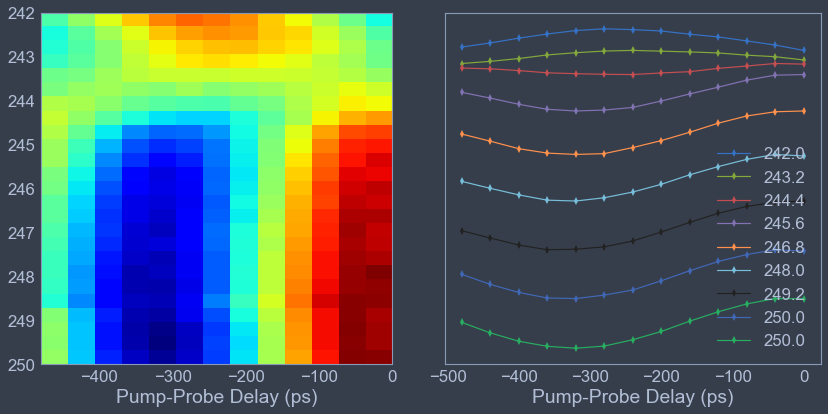

,,scancoord,kerr_rotation,scan_type_2d,scan_type_1d,lockin2x,lockin2r,lockin1r,voltage,laserpower,cwetalon,laser_h,laser_v,temperature,file_index,b_external,wavelength
index_2d,index_1d,,,,,,,,,,,,,,,,
1.0,0,-480.1108,-0.01365,b_external,probe_delay,8.720000e-04,9.992000e-43,0.01365,0.0,0.734,-0.135,0.000000e+00,-1.442000e-01,9.994,55,242.0,818.58
2.0,0,-480.1108,-0.02040,b_external,probe_delay,1.244400e-33,1.100000e-03,0.02055,0.0,0.779,-0.187,9.947700e+00,-9.522000e-11,10.003,62,242.4,818.58
3.0,0,-480.1108,-0.01905,b_external,probe_delay,1.088600e-03,1.177400e-03,0.01905,0.0,0.765,-0.159,9.934000e+00,-9.630000e-01,9.990,63,242.8,818.58
4.0,0,-480.1108,-0.01655,b_external,probe_delay,1.066660e-03,9.520000e-04,0.01645,0.0,0.772,-0.190,0.000000e+00,-1.030000e-01,10.006,64,243.2,818.58
5.0,0,-480.1108,-0.00955,b_external,probe_delay,9.550000e-04,9.200000e-04,0.00945,0.0,0.769,-0.158,9.220000e-01,-9.224000e-01,10.016,65,243.6,818.58
6.0,0,-480.1108,-0.00765,b_external,probe_delay,9.666000e-04,1.101660e-02,0.00765,0.0,0.745,-0.134,8.997700e-01,-8.690000e-01,9.997,66,244.0,818.58
7.0,0,-480.1108,-0.00035,b_external,probe_delay,8.960000e-04,9.928000e-03,0.00045,0.0,0.761,-0.155,2.000000e-02,-9.750000e-01,10.009,67,244.4,818.58
8.0,0,-480.1108,0.00190,b_external,probe_delay,8.884000e-04,8.340000e-04,0.00210,0.0,0.753,-0.148,1.700000e-01,-9.540000e-01,9.989,68,244.8,818.58
9.0,0,-480.1108,-0.00065,b_external,probe_delay,8.080000e-04,8.882000e-03,0.00055,0.0,0.778,-0.140,9.340000e-01,2.000000e-03,10.001,69,245.2,818.58


In [19]:
# TAKE A LOOK AT ANY RUN INDIVIDUALLY
run_index = 21
valid_run_ids = full_dataframe.index.get_level_values('run_id').unique()
print("Run {} of valid IDs: {}".format(run_index, list(valid_run_ids)))
assert run_index in valid_run_ids
run_dataframe = full_dataframe.xs(run_index, level='run_id')

print('---')
print('metadata of first file in run:')
file_index = run_dataframe['file_index'].values[0]
for key, val in file_metadata_list[file_index].items():
    print("{}: {}".format(key, val))
print('---')


# OPTIONAL: screw around with it
# run_dataframe = run_dataframe.loc[run_dataframe['scancoord'] <= 0]

figure_size = (12, 6)
num_waterfall_plots = 9
data_column = 'kerr_rotation'
x_values_column = 'scancoord'
y_values_column = run_dataframe['scan_type_2d'].values[0]  # useful if works
# y_values_column = None
xlabel = "Pump-Probe Delay (ps)"
ylabel = None
imshow_kwargs = {'aspect': 1.0,
                 'origin': 'upper'}
plt.figure(figsize=figure_size)
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
dfplot.plot_dataframe_colorplot(run_dataframe, data_column,
                                x_values_column, y_values_column,
                                xlabel=xlabel, ylabel=ylabel,
                                ax=ax1, **imshow_kwargs)
dfplot.plot_dataframe_waterfall(run_dataframe, data_column,
                                num_waterfall_plots,
                                x_values_column, y_values_column,
                                xlabel=xlabel, ylabel=None,
                                ax=ax2, add_legend=True)
ax2.yaxis.set_ticklabels([])

# OPTIONAL: tinkering again
# ax1.xaxis.set_ticklabels([130, 140, 150, 140, 130])

plt.show()
# run_dataframe.head()  # view first 5 rows
run_dataframe.groupby(level=-2).head(1)  # view 1st row of each 2d index

In [ ]:
# TAKE A LOOK AT ANY SUBFILE
# tip: if you want to look at a specific run,
#      pick out a file_index from run-plotting cell
file_index = 10
for key, val in file_metadata_list[file_index].items():
    print("{}: {}".format(key, val))
file_dataframes_list[file_index].plot(x='scancoord', y='kerr_rotation', ylim=[-0.02, 0.02])
file_dataframes_list[file_index].head()

In [4]:
# # EXAMPLE - REORDERING AXES
# df = full_dataframe
# df = df.groupby(level=[-3, -2]).head(5)
# new_index = df.index.reorder_levels([-2, -3, -1])
# df.index = new_index
# df

## Pandas-lmfit helper functions

In [ ]:
from experimentdataanalysis.analysis.dataframe_processing \
    import df_extract_dataset_indexed_matrices, \
           df_extract_vector_lists_by_dataset, \
           df_transform_dataset_df_to_fit_row, \
           df_minimize_fcn_on_datasets, \
           df_minimize_fcn_across_linked_datasets
from experimentdataanalysis.analysis.fit_tools \
    import create_residuals_fcn

# df_extract_dataset_indexed_matrices(df, column_names)
# df_extract_vector_lists_by_dataset(df, column_names)
# df_transform_dataset_df_to_fit_row(df, group_fit_params_dict,
#                                    fit_params_to_add,
#                                    column_aggregation_dict={},
#                                    keep_const_columns=True)
# df_minimize_fcn_on_datasets(df, residuals_fcn, fit_params,
#                             independent_vars_columns,
#                             measured_data_column,
#                             *res_args,
#                             column_aggregation_dict={},  # KEYWORDS ONLY!
#                             keep_const_columns=True,
#                             **res_kwargs)

# WORK IN PROGRESS:
# df_minimize_fcn_across_linked_datasets(df, residuals_fcn, fit_params,
#                                        dataset_params_unpacking_fcn,
#                                        independent_vars_columns,
#                                        measured_data_column,
#                                        *res_args,
#                                        column_aggregation_dict={},  # KEYWORDS ONLY!
#                                        keep_const_columns=True,
#                                        **res_kwargs)

## Dataset fit model and residuals

In [52]:
# GLOBAL CONSTANTS
GFACTORCONSTANT = 1.3996e-5  # 1/(ps*mTesla), = bohr magneton/2*pi*hbar
LASER_REPRATE = 13158  # ps period

from experimentdataanalysis.simulations.simple_trkr_rsa_simulation \
    import trkr_decaying_cosine

auto_residuals_trkr_decaying_cosine = \
    create_residuals_fcn(trkr_decaying_cosine,
                         ['delay_time', 'total_bfield'])

# def residuals_trkr_decaying_cosine(params,
#                                    delay_time, total_bfield,
#                                    measured_data=None):
#     # unpack parameters:
#     #  extract .value attribute for each parameter
#     param_values = params.valuesdict()
#     gfactor      = param_values['gfactor']
#     amplitude    = param_values['amplitude']
#     phase_offset = param_values['phase_offset']
#     y_offset     = param_values['y_offset']
#     result = trkr_decaying_cosine(
#                 delay_time, total_bfield,  # <-independent vars
#                 pulse_amplitude,  # <- params to unpack
#                 gfactor, spin_lifetime,
#                 initial_phase, extra_phase_offset,
#                 slope, offset)
#     if measured_data is None:
#         return result
#     return result - measured_data

## Dataset fit parameter setup and constraints

In [54]:
from lmfit import Parameters

params_guesses = [('pulse_amplitude',     {'value' : 1e-3,
                                           'min'   : 0.0,
                                           'max'   : 1.0}),
                  ('gfactor',             {'value' : 0.40,
                                           'min'   : 0.35,
                                           'max'   : 0.50,
                                           'vary'  : True}),
                  ('spin_lifetime',       {'value' : 2000.0,
                                           'min'   : 0.0,
                                           'max'   : 1e5}),
                  ('initial_phase',       {'value' : 0.0,
                                           'vary'  : False}),
                  ('extra_phase_offset',  {'value' : 0.0,
                                           'min'   : -np.pi,
                                           'max'   : +np.pi}),
                  ('slope',               {'value' : 0.0,
                                           'min'   : -1e-2,
                                           'max'   : +1e-2}),
                  ('offset',              {'value' : 0.0,
                                           'min'   : -1e-2,
                                           'max'   : +1e-2}),
                 ]
fit_params = Parameters()
for param_name, param_guess_dict in params_guesses:
    fit_params.add(param_name, **param_guess_dict)

## 1D Fit to fake data

,file_index,b_external,wavelength,pulse_amplitude,pulse_amplitude_error,gfactor,gfactor_error,spin_lifetime,spin_lifetime_error,initial_phase,extra_phase_offset,extra_phase_offset_error,slope,slope_error,offset,offset_error
index_2d,,,,,,,,,,,,,,,,
0.0,0.0,200.0,836.00,0.386819,0.008851,0.405162,0.000924,7517.226139,857.867390,0.0,0.059266,0.025113,-8.937828e-06,6.912700e-06,0.010000,0.007360
1.0,1.0,200.0,836.00,0.410003,0.005446,0.404725,0.000278,4945.875900,120.927935,0.0,0.063383,0.013178,-7.896465e-07,6.317701e-07,0.006159,0.002477
2.0,2.0,200.0,836.00,0.408352,0.001084,0.404369,0.000084,5039.222647,35.580412,0.0,0.064599,0.002788,-1.221752e-07,2.570474e-07,0.001602,0.000560
3.0,3.0,200.0,836.17,0.392691,0.005408,0.405171,0.000289,4934.963889,124.821427,0.0,0.070988,0.013674,-7.553231e-07,6.272968e-07,0.006618,0.002459


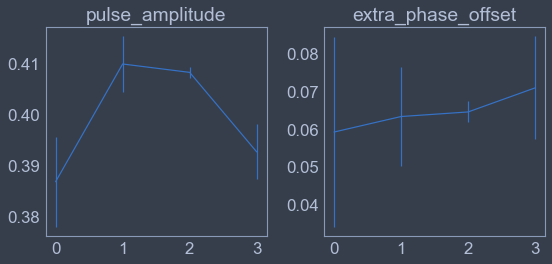

In [57]:
df = full_dataframe.xs(0, level='run_id')
fit_output_df = df
residuals_fcn = auto_residuals_trkr_decaying_cosine
fit_params = fit_params
independent_vars_columns = ["probe_delay", "b_external"]
measured_data_column = "lockin2"
fit_params_to_add = ['amplitude', 'phase_offset']
column_aggregation_dict = {'time_elapsed': lambda x: x.head(1).values}  # keep first time
keep_const_columns = True

minimize_results, results_df = \
    df_minimize_fcn_on_datasets(df, residuals_fcn, fit_params,
                                independent_vars_columns,
                                measured_data_column,
                                column_aggregation_dict=column_aggregation_dict,  # keywords only!
                                keep_const_columns=keep_const_columns)

# FILTER OUT BAD FITS
good_result_indices = []
for dataset_index, result in enumerate(minimize_results):
    red_flag = False
    if result.params['extra_phase_offset'].stderr > np.pi / 2:
        print("dataset {}: ".format(dataset_index) +
              "phase offset error too large, ignoring dataset...")
        red_flag = True
    if not red_flag:
        good_result_indices.append(dataset_index)
#        fit_output_df[measured_data_column].iloc[dataset_index] = \
            
trimmed_results_df = results_df.iloc[good_result_indices]
trimmed_minimize_results = [minimize_results[ind]
                            for ind in good_result_indices]

plt.figure(figsize=(8,4))
ax1 = plt.subplot(1,2,1)
plt.errorbar(x=trimmed_results_df.index,
             y=trimmed_results_df.pulse_amplitude,
             yerr=trimmed_results_df.pulse_amplitude_error)
# new_df['amplitude'].plot.line(ax=ax1)
plt.title('pulse_amplitude')
ax2 = plt.subplot(1,2,2)
plt.errorbar(x=trimmed_results_df.index,
             y=trimmed_results_df.extra_phase_offset,
             yerr=trimmed_results_df.extra_phase_offset_error)
# new_df['phase_offset'].plot.line(ax=ax2)
plt.title('extra_phase_offset')
results_df.head(5)


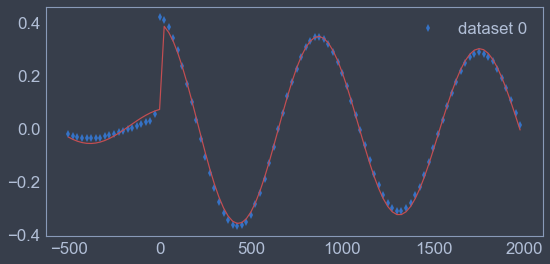

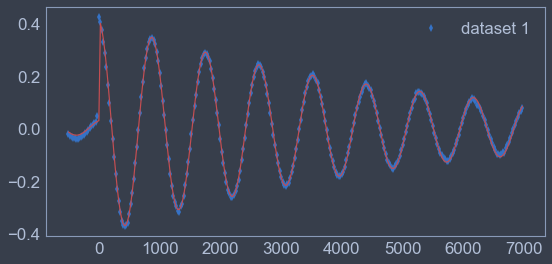

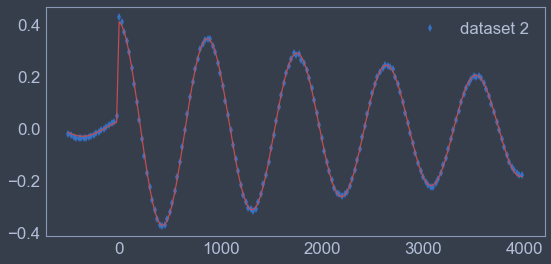

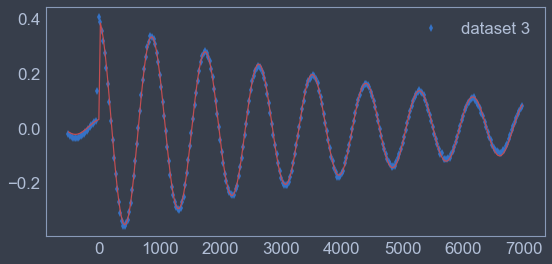

In [42]:
# PLOT FIT RESULTS
result_indices_to_plot = [0, 1, 2, 3]
for result_index in result_indices_to_plot:
    dataset_index_2d = np.int(results_df.index[result_index])
    result = minimize_results[dataset_index_2d]
    xvals = df.loc[dataset_index_2d].probe_delay
    yvals = df.loc[dataset_index_2d].lockin2
    fit_yvals = residuals_fcn(result.params,
                              df.loc[dataset_index_2d].probe_delay,
                              df.loc[dataset_index_2d].b_external)
    plt.figure(figsize=(8,4))
    plt.plot(xvals, yvals, 'bd', label='dataset {}'.format(result_index))
    plt.plot(xvals, fit_yvals, 'r')
    plt.legend()